In [1]:
from pathlib import Path
import sys
sys.path.append('../src/rate')
from constants import SCORED_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from treatment_effects import treatment_effects_pipeline
from utils_plotting import plot_scores, naive_vs_RATE, rewrite_bias, synthetic_subplots, sample_rewrites, sample_rewrites_tabular
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

2025-01-24 12:30:12,361 - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-01-24 12:30:12,363 - INFO - NumExpr defaulting to 16 threads.


In [2]:
file_paths = [
    f"{SCORED_DIR}/typos/imdb_vowels_30typos_complete_scored_20241120_162935.jsonl",
    f"{SCORED_DIR}/complete/eli5_length_complete_scored_20240919_170111.jsonl",
    f"{SCORED_DIR}/complete/hh_rlhf_sentiment_scored_complete.jsonl",
    f"{SCORED_DIR}/complete/imdb_sentiment_complete_scored_20240919_152739.jsonl",
    f"{SCORED_DIR}/complete/helpsteer_complexity_complete_scored.jsonl",
    f"{SCORED_DIR}/complete/helpsteer_helpfulness_complete_scored.jsonl"
]

model_key = "ArmoRM"
samples = sample_rewrites(file_paths, model_key)
print(samples)

\subsection*{Imdb_vowels_30typos_complete_scored, 20241120}

\textbf{Reward Question}:
Write a movie review: 

\textbf{Original} (W = 0):
There's so little here of the fantastic Anne Rice book that what IS here makes no sense. Some of the characters--intense and surprising characters--don't make it to the screen at all, and those who do are watered down to the point that there's no reason for their existence.<br /><br />Where's the relationship between Christophe and Marcel? Where's the continued affair between Marcel and Juliet? Why does Dolly Rose appear at all, since her story's never explained? Where's the rape and redemption of Marie, whose greatest attribute (and downfall) is that she can pass for white--and her marriage to Richard? Why does the film end with Marcel's beating at the hands of his father? We learn nothing of Aglae beyond that she's a bitch who hates her husband; why no backstory explaining this hatred? <br /><br />As for the performances, there's not a one that's b

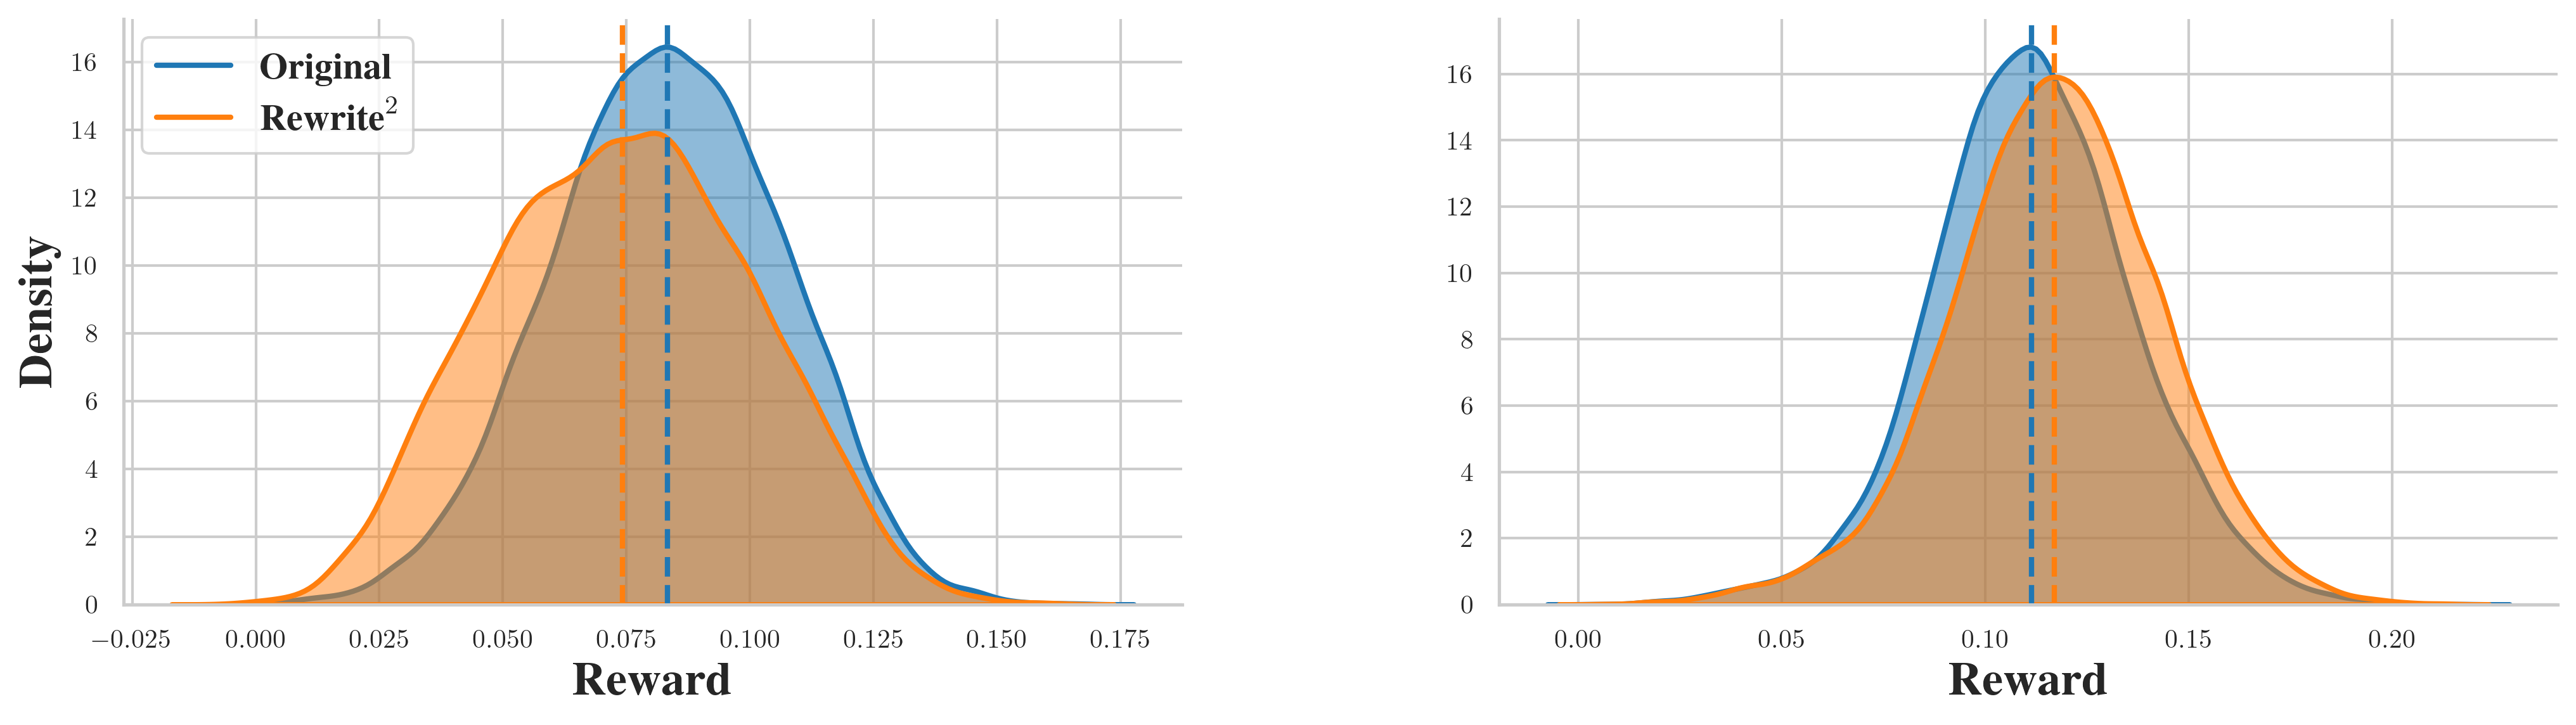

In [3]:
hh_rlhf_template = {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
eli5_template = {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    }

templates = [hh_rlhf_template, eli5_template]
plot_scores(templates, SCORED_DIR)

In [4]:
# load the json file
data_dir = Path("/net/projects/veitch/prompt_distributions/data/scored")
complete_dir = data_dir / "complete"

eli5_length = load_dataset_from_json(complete_dir / "eli5_length_complete_scored_20240919_170111.jsonl")
helpsteer_complexity = load_dataset_from_json(complete_dir / "helpsteer_complexity_complete_scored.jsonl")
helpsteer_helpfulness = load_dataset_from_json(complete_dir / "helpsteer_helpfulness_complete_scored.jsonl")
hh_rlhf_sentiment = load_dataset_from_json(complete_dir / "hh_rlhf_sentiment_scored_complete.jsonl")
imdb_length = load_dataset_from_json(complete_dir / "imdb_length_complete_scored_20240921_172425.jsonl")
imdb_sentiment = load_dataset_from_json(complete_dir / "imdb_sentiment_complete_scored_20240919_152739.jsonl")

In [5]:
# concatenate the length and sentiment datasets
def concat_datasets(dataset_A, dataset_B):
    # create temp keys for each dataset
    new_dataset_A = {f"A_{key}": value for key, value in dataset_A.items()}
    new_dataset_B = {f"B_{key}": value for key, value in dataset_B.items()}
    # concatenate the two dictionaries
    concatenated_dataset = {**new_dataset_A, **new_dataset_B}
    return concatenated_dataset

# some datasets have d["0"]["RLHFlow/ArmoRM-Llama3-8B-v0.1"] and others d["0"]["ArmoRM"], standardize to the former.
def standardize_ArmoRM(dataset):
    new_dataset = {}
    for key, value in dataset.items():
        # Check if "ArmoRM" exists as a key in the current level of the dictionary
        if "ArmoRM" in value:
            value["RLHFlow/ArmoRM-Llama3-8B-v0.1"] = value.pop("ArmoRM")
        new_dataset[key] = value
    return new_dataset

length = standardize_ArmoRM(concat_datasets(imdb_length, eli5_length))
complexity = standardize_ArmoRM(helpsteer_complexity)
helpfulness = standardize_ArmoRM(helpsteer_helpfulness)
sentiment = standardize_ArmoRM(concat_datasets(imdb_sentiment, hh_rlhf_sentiment))

In [6]:
CONCEPTS = {
    "length": length,
    "complexity": complexity,
    "helpfulness": helpfulness,
    "sentiment": sentiment,
}

REWARD_MODELS = [
    "sfairXC/FsfairX-LLaMA3-RM-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "RLHFlow/ArmoRM-Llama3-8B-v0.1"
]

all_data = []
all_templates = []

for concept, dataset in CONCEPTS.items():
    for rm_key in REWARD_MODELS:
        # We set up a minimal template that the pipeline function expects
        # (the pipeline uses e.g. reward_key, original=..., rewrite=..., etc.)
        effects_template = {
            "reward_key": rm_key,
            "w_original_key": "original",
            "w_counterfactual_key": "rewrite",
            "w_rewritten_rewrite_key": "rewritten rewrite",
            "dataset_name": "combined",  # or something descriptive
            "concept": concept,
            "score": rm_key,            # fill in so we know which model
        }

        # Now compute the effects for the entire combined dataset with that reward key
        effects = treatment_effects_pipeline(dataset, **effects_template)

        # Add the concept, model name, etc. so it’s easy to track
        # (the pipeline might already be returning some of this, but just to be sure)
        effects["concept"] = concept
        effects["score"] = rm_key

        all_data.append(effects)
        all_templates.append(effects_template)

2025-01-24 12:30:29,370 - INFO - Number of w=1 examples: 25253
2025-01-24 12:30:29,370 - INFO - Number of w=0 examples: 24748


2025-01-24 12:30:29,421 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.39030453628598316,
    'ATE_rewritten_rewrite_stderr': 0.010139742644725091,
    'ATE_single_rewrite': 0.6908812290673128,
    'ATE_single_rewrite_stderr': 0.005254430242160952,
    'ATT_rewritten_rewrite': 0.5365678994711223,
    'ATT_rewritten_rewrite_stderr': 0.013311674322598655,
    'ATT_single_rewrite': 0.05419359088949527,
    'ATT_single_rewrite_stderr': 0.004397918519562226,
    'ATU_rewritten_rewrite': 0.24105656834860234,
    'ATU_rewritten_rewrite_stderr': 0.015170974159443794,
    'ATU_single_rewrite': 1.3405609174019038,
    'ATU_single_rewrite_stderr': 0.007667693440318097,
    'Y0_count': 24748,
    'Y1_count': 25253,
    'naive_effect': 1.324609282602708,
    'naive_effect_stderr': 0.01192538892765282,
    'reward_std': 1.3355473435068927}
2025-01-24 12:30:29,427 - INFO - Calculated ATE (from ATT and ATU): 0.39030453628598355
2025-01-24 12:30:29,453 - INFO - Rewrite effects: {   'rewrite


=== Model: sfairXC/FsfairX-LLaMA3-RM-v0.1 ===
Concept: complexity           | Naive: 0.488 ± 0.020 | RATE: 0.325 ± 0.011
Concept: helpfulness          | Naive: 1.253 ± 0.016 | RATE: 0.393 ± 0.010
Concept: length               | Naive: 0.992 ± 0.009 | RATE: 0.292 ± 0.008
Concept: sentiment            | Naive: 0.448 ± 0.009 | RATE: 0.537 ± 0.007

=== Model: NCSOFT/Llama-3-OffsetBias-RM-8B ===
Concept: complexity           | Naive: 0.273 ± 0.020 | RATE: -0.324 ± 0.011
Concept: helpfulness          | Naive: 1.202 ± 0.015 | RATE: 0.161 ± 0.010
Concept: length               | Naive: 0.338 ± 0.009 | RATE: 0.099 ± 0.008
Concept: sentiment            | Naive: 0.365 ± 0.009 | RATE: 0.509 ± 0.007

=== Model: RLHFlow/ArmoRM-Llama3-8B-v0.1 ===
Concept: complexity           | Naive: 0.325 ± 0.020 | RATE: 0.152 ± 0.011
Concept: helpfulness          | Naive: 1.036 ± 0.015 | RATE: 0.308 ± 0.011
Concept: length               | Naive: 0.337 ± 0.009 | RATE: -0.013 ± 0.006
Concept: sentiment            | 

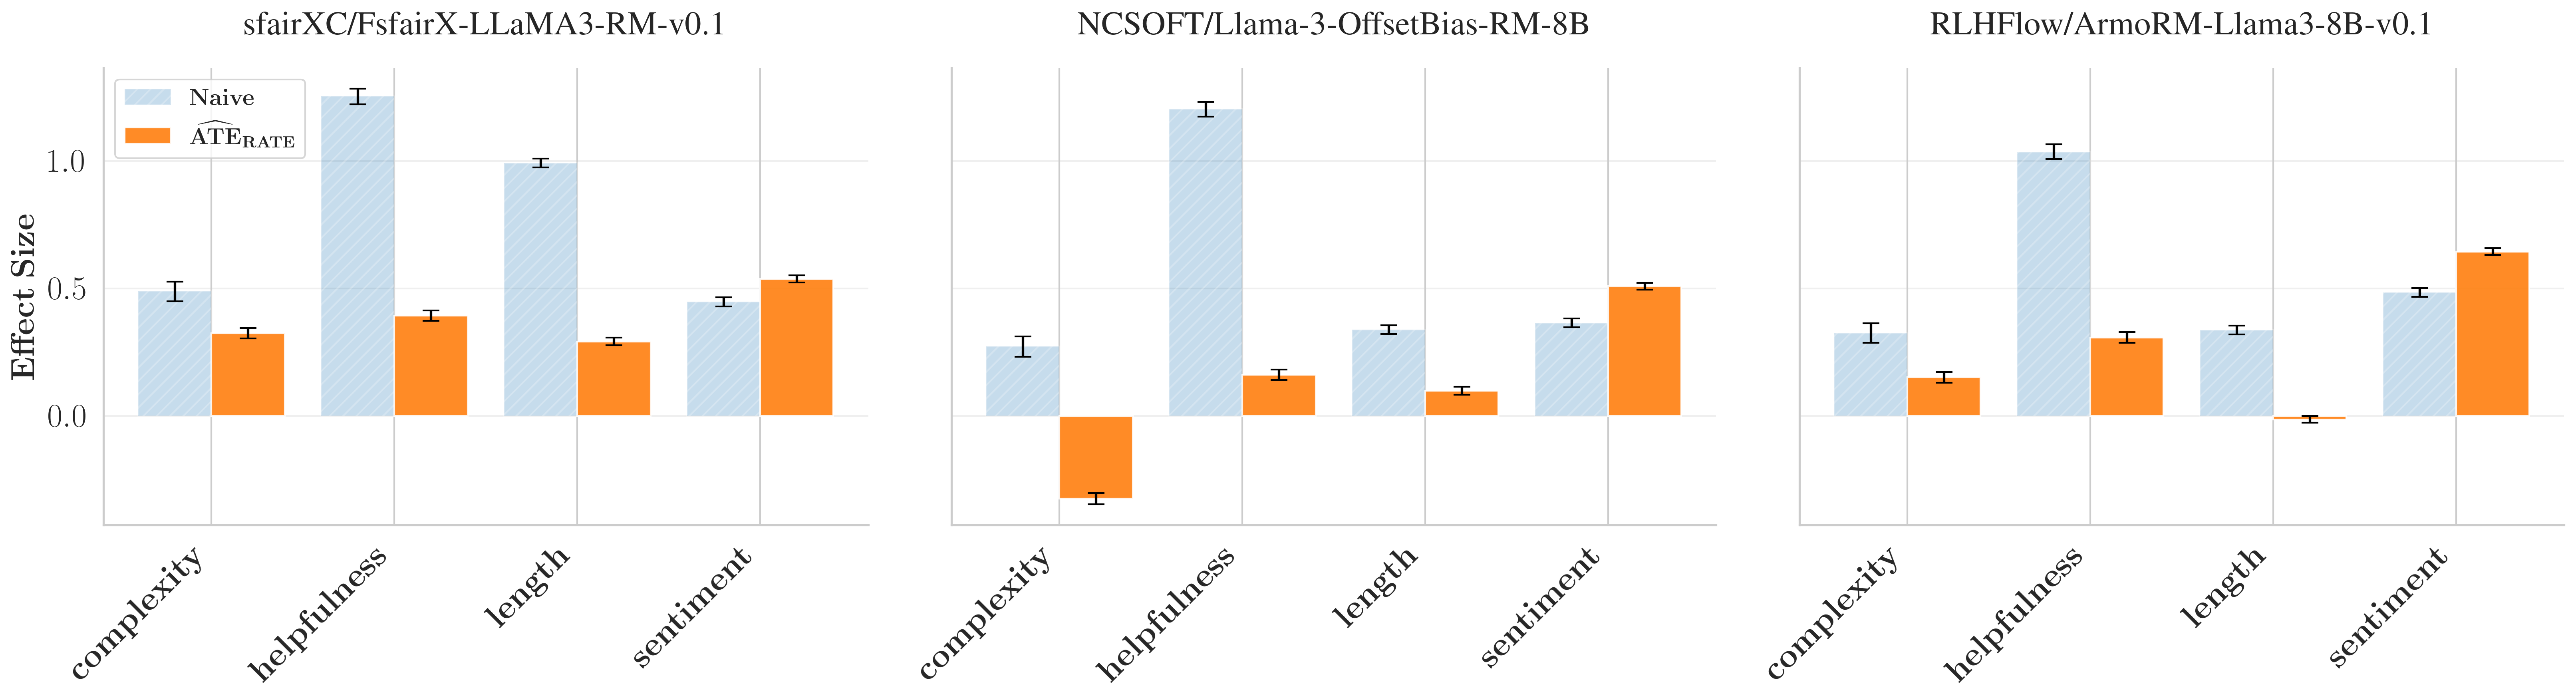

In [7]:
naive_vs_RATE(
    all_data=all_data,
    all_templates=all_templates,
    reward_models=REWARD_MODELS,
    normalize=True
)

In [8]:
all_data

[{'naive_effect': 1.324609282602708,
  'naive_effect_stderr': 0.01192538892765282,
  'ATE_single_rewrite': 0.6908812290673128,
  'ATE_single_rewrite_stderr': 0.005254430242160952,
  'ATT_single_rewrite': 0.05419359088949527,
  'ATT_single_rewrite_stderr': 0.004397918519562226,
  'ATU_single_rewrite': 1.3405609174019038,
  'ATU_single_rewrite_stderr': 0.007667693440318097,
  'ATE_rewritten_rewrite': 0.39030453628598316,
  'ATE_rewritten_rewrite_stderr': 0.010139742644725091,
  'ATT_rewritten_rewrite': 0.5365678994711223,
  'ATT_rewritten_rewrite_stderr': 0.013311674322598655,
  'ATU_rewritten_rewrite': 0.24105656834860234,
  'ATU_rewritten_rewrite_stderr': 0.015170974159443794,
  'reward_std': 1.3355473435068927,
  'Y1_count': 25253,
  'Y0_count': 24748,
  'concept': 'length',
  'score': 'sfairXC/FsfairX-LLaMA3-RM-v0.1'},
 {'naive_effect': 0.3756377664601436,
  'naive_effect_stderr': 0.009924219405942531,
  'ATE_single_rewrite': 0.31701136973354327,
  'ATE_single_rewrite_stderr': 0.0035

length


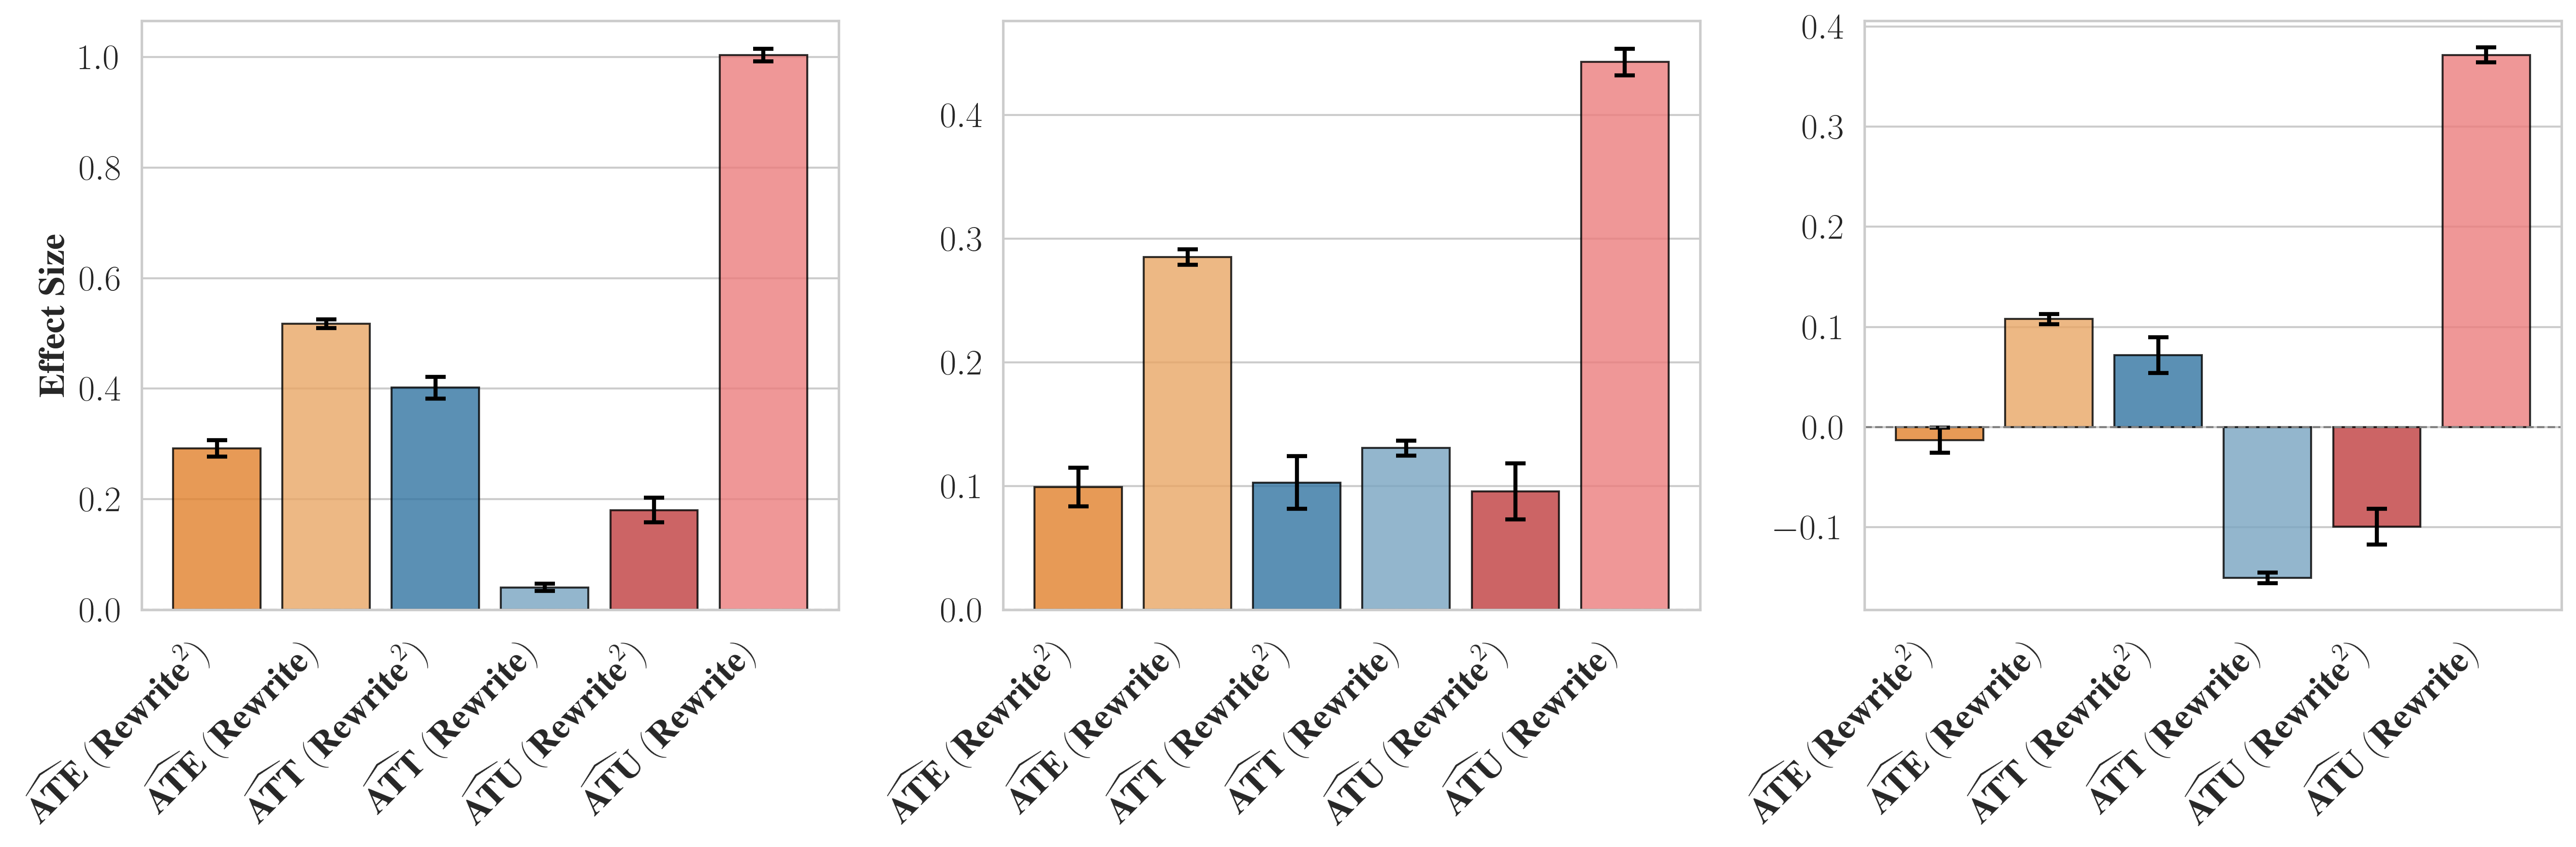

complexity


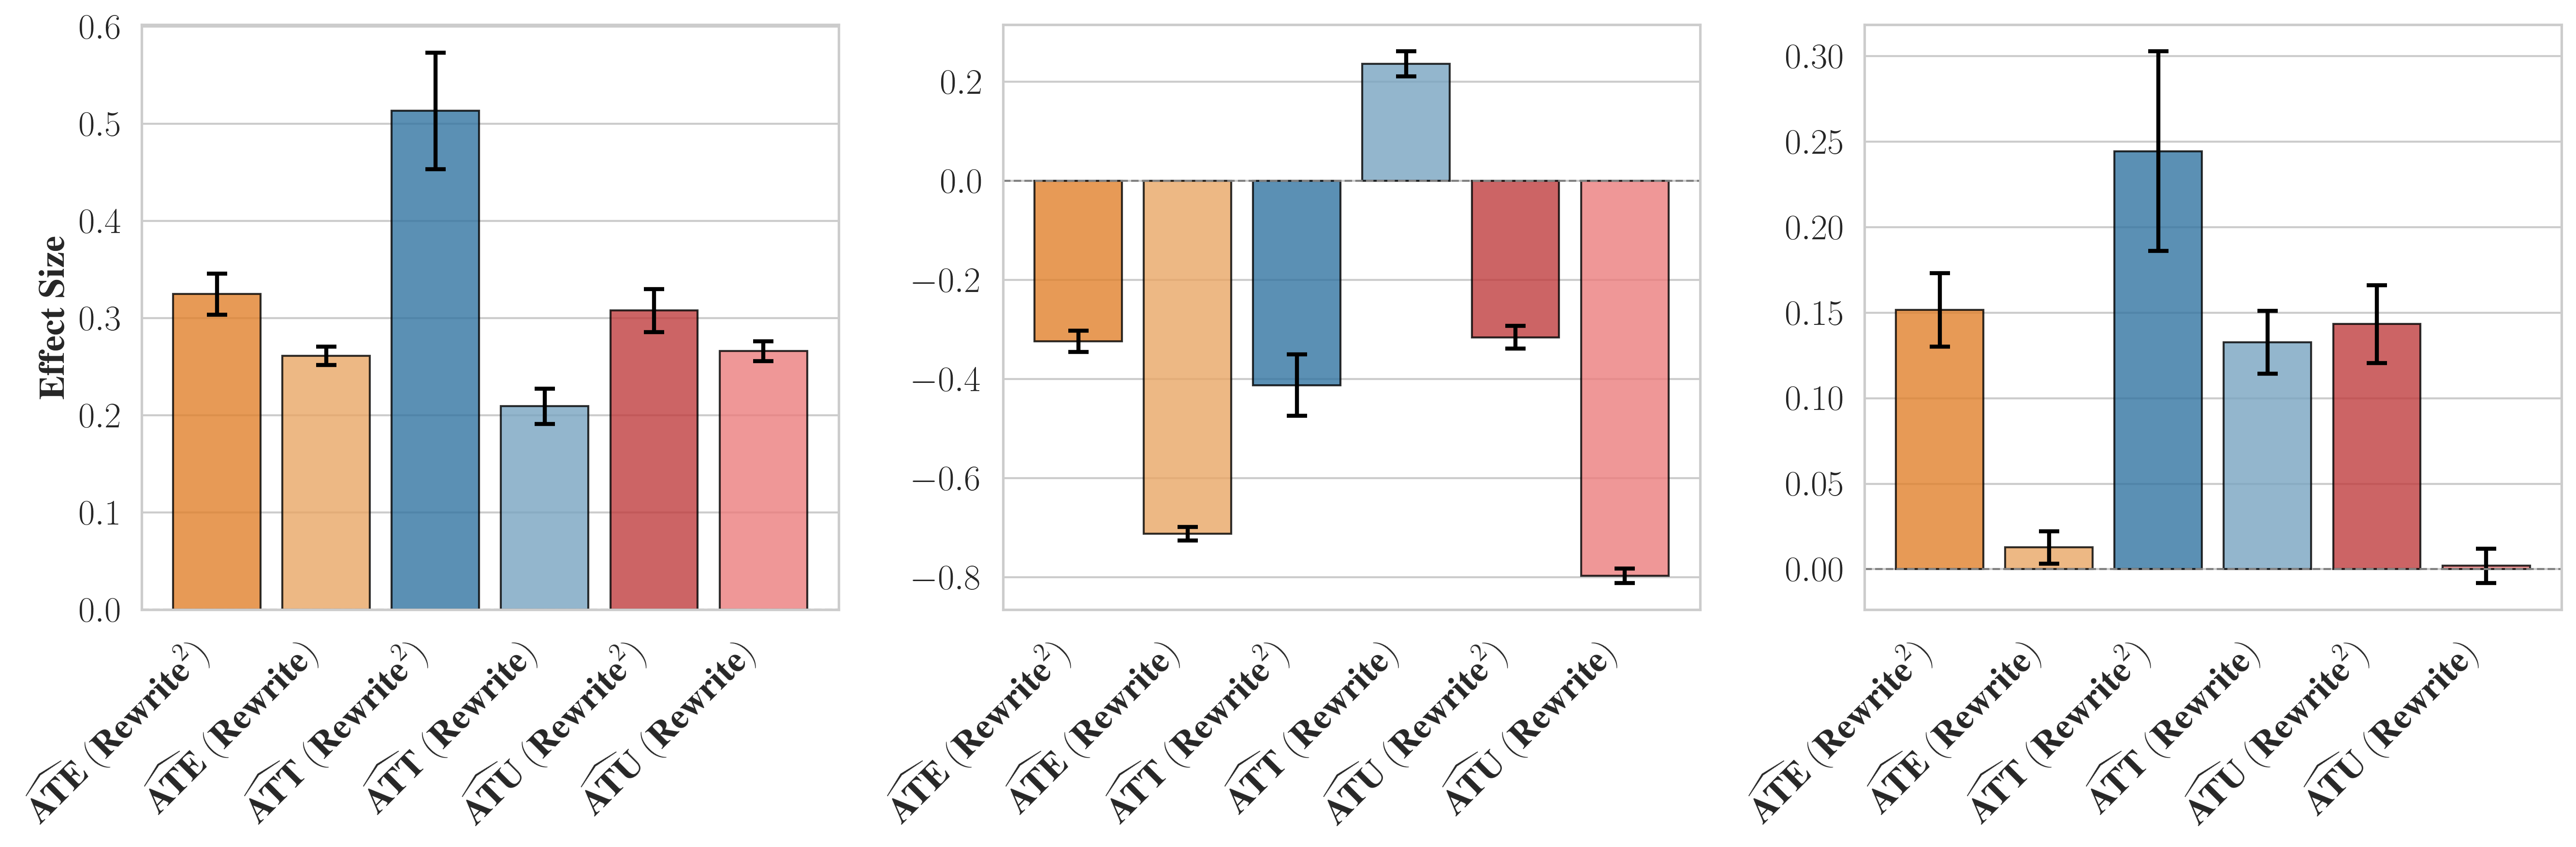

helpfulness


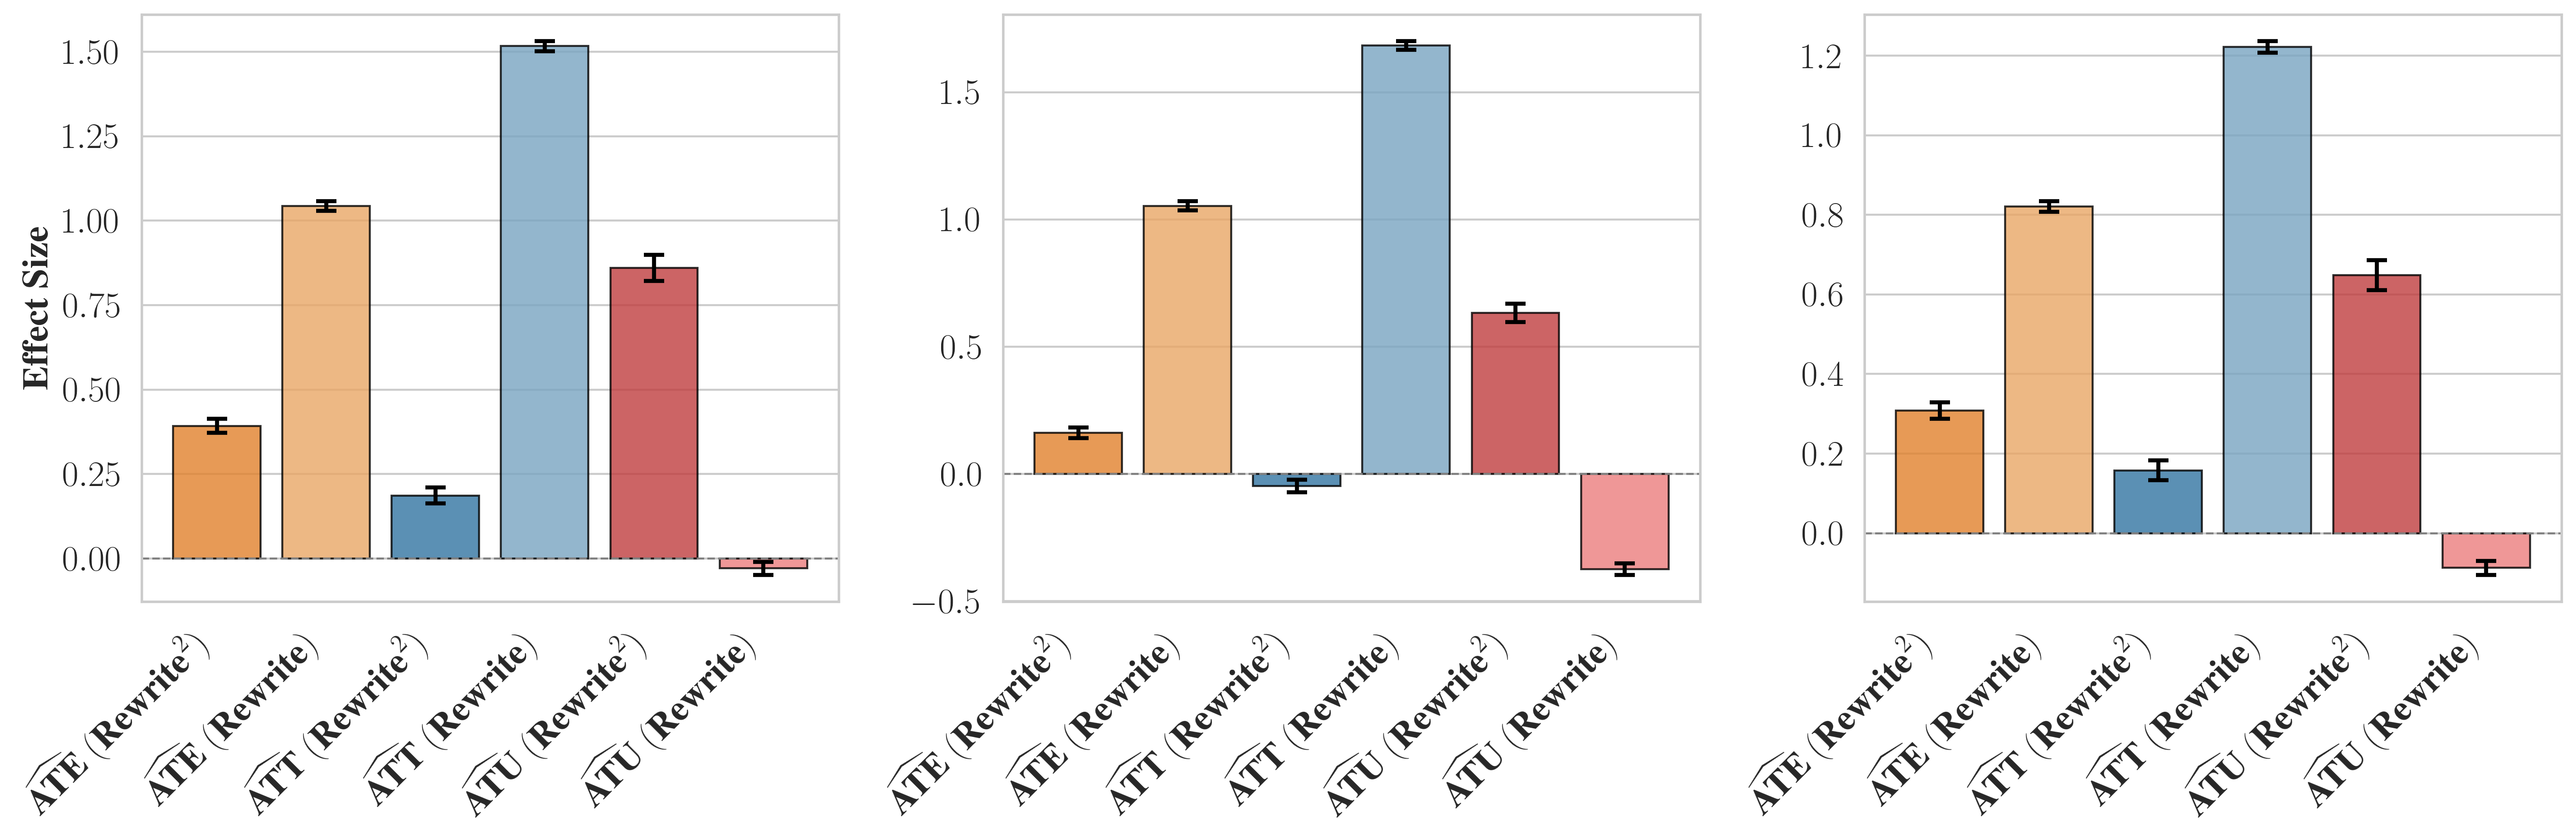

sentiment


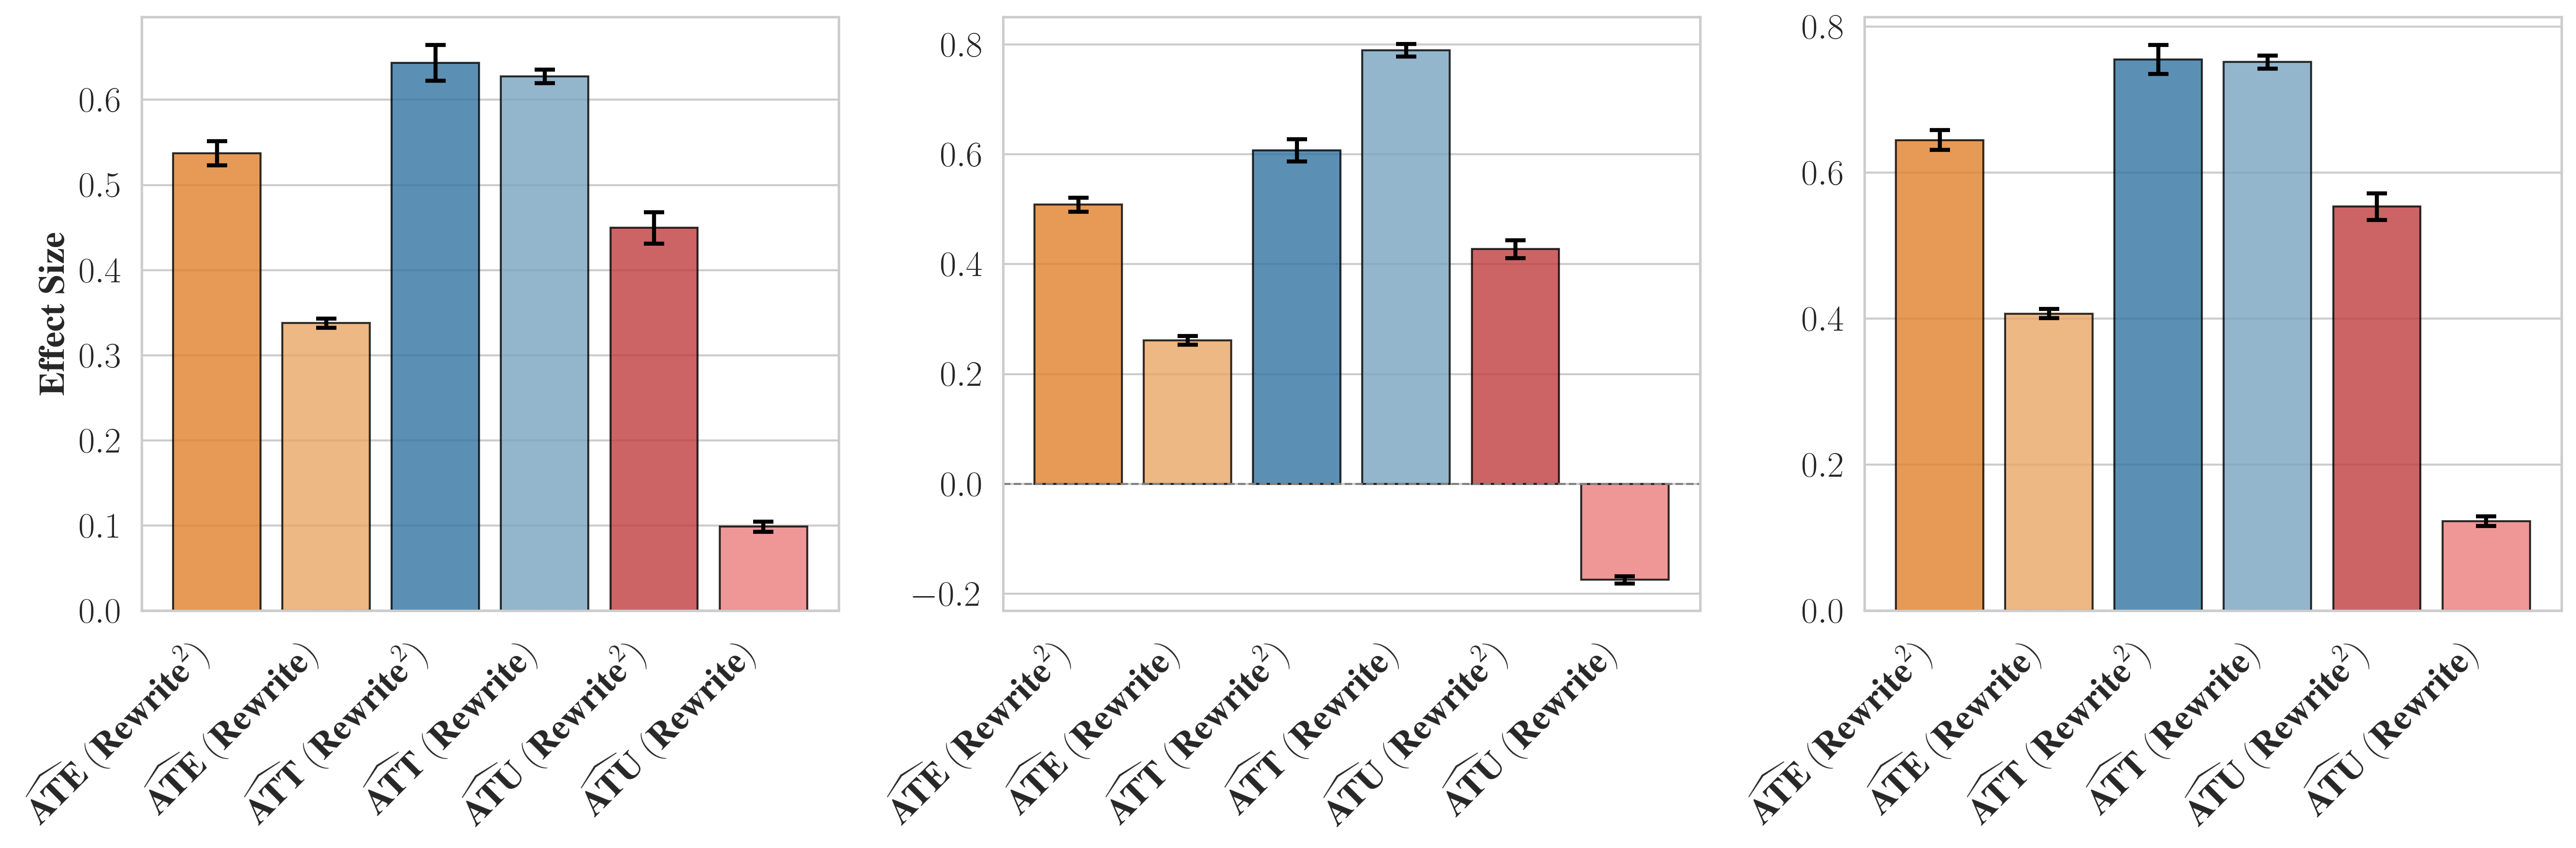

In [9]:
# for each concept, do this. we find "concept" in all_data and then filter by that
for concept in CONCEPTS.keys():
    effects_data = [d for d in all_data if d["concept"] == concept]
    
    # order them by "score" = "FsfairX-LLAMA3-RM-v0.1","NCSOFT/Llama-3-OffsetBias-RM-8B", "RLHFlow/ArmoRM-Llama3-8B-v0.1"
    ordered_effects_data = sorted(effects_data, key=lambda x: REWARD_MODELS.index(x["score"]))

    # print the concept
    print(concept)

    rewrite_bias(ordered_effects_data)

In [10]:
config = load_dataset_from_json(Path("config_plotting_synth.jsonl"))

# make into list of dictionaries
synthetic_templates = [value for value in config.values()]

In [11]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    synthetic_data.append(effects)

2025-01-24 12:30:36,663 - INFO - Number of w=1 examples: 4004
2025-01-24 12:30:36,665 - INFO - Number of w=0 examples: 5372
2025-01-24 12:30:36,681 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.0844035465969567,
    'ATE_rewritten_rewrite_stderr': 0.04930379836414409,
    'ATE_single_rewrite': 0.16884899790376523,
    'ATE_single_rewrite_stderr': 0.01354892736882799,
    'ATT_rewritten_rewrite': 0.2384955123230651,
    'ATT_rewritten_rewrite_stderr': 0.06947906261246611,
    'ATT_single_rewrite': -0.330754465871043,
    'ATT_single_rewrite_stderr': 0.01630709816868453,
    'ATU_rewritten_rewrite': -0.0304483206344911,
    'ATU_rewritten_rewrite_stderr': 0.0685568950220651,
    'ATU_single_rewrite': 0.5412265610002531,
    'ATU_single_rewrite_stderr': 0.01873701381382012,
    'Y0_count': 5372,
    'Y1_count': 4004,
    'naive_effect': -0.2572232905938362,
    'naive_effect_stderr': 0.06290409599455854,
    'reward_std': 3.068588378397191}
2025-01-24 12:30:36,682 - INFO - Ca

2025-01-24 12:30:37,006 - INFO - Number of w=1 examples: 4022
2025-01-24 12:30:37,024 - INFO - Number of w=0 examples: 5352
2025-01-24 12:30:37,030 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.0893972401733919,
    'ATE_rewritten_rewrite_stderr': 0.04933470045521202,
    'ATE_single_rewrite': 0.14209101636042998,
    'ATE_single_rewrite_stderr': 0.013507717134024325,
    'ATT_rewritten_rewrite': 0.24820265587380363,
    'ATT_rewritten_rewrite_stderr': 0.06951142895434642,
    'ATT_single_rewrite': -0.33064456344065773,
    'ATT_single_rewrite_stderr': 0.015771653898299983,
    'ATU_rewritten_rewrite': -0.02994419890490707,
    'ATU_rewritten_rewrite_stderr': 0.068794649411223,
    'ATU_single_rewrite': 0.49734933137537296,
    'ATU_single_rewrite_stderr': 0.01908765882416923,
    'Y0_count': 5352,
    'Y1_count': 4022,
    'naive_effect': 0.1898177335010367,
    'naive_effect_stderr': 0.06301414138720153,
    'reward_std': 3.0676933431269915}
2025-01-24 12:30:37,030 - INF

In [12]:
config = load_dataset_from_json(Path("config_plotting_help_synth.jsonl"))

# make into list of dictionaries
help_synthetic_templates = [value for value in config.values()]

In [13]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    help_synthetic_data.append(effects)

2025-01-24 12:30:39,008 - INFO - Number of w=1 examples: 2574
2025-01-24 12:30:39,009 - INFO - Number of w=0 examples: 2574
2025-01-24 12:30:39,013 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.014393984818637143,
    'ATE_rewritten_rewrite_stderr': 0.00079378864033712,
    'ATE_single_rewrite': 0.01957111698185457,
    'ATE_single_rewrite_stderr': 0.0005043422673346951,
    'ATT_rewritten_rewrite': 0.0054083771461102825,
    'ATT_rewritten_rewrite_stderr': 0.0011309362696518663,
    'ATT_single_rewrite': 0.04116395636899113,
    'ATT_single_rewrite_stderr': 0.0006486281561102675,
    'ATU_rewritten_rewrite': 0.02337959249116403,
    'ATU_rewritten_rewrite_stderr': 0.0010911649065769267,
    'ATU_single_rewrite': -0.002021722405281992,
    'ATU_single_rewrite_stderr': 0.00048425794318990095,
    'Y0_count': 2574,
    'Y1_count': 2574,
    'naive_effect': 0.031895498183147755,
    'naive_effect_stderr': 0.000981691571743384,
    'reward_std': 0.03521797135263725}
2025-01-24

Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: 0.04676868149957367
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.10007485133004765
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: -0.011395818249528256
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.041311543802865024


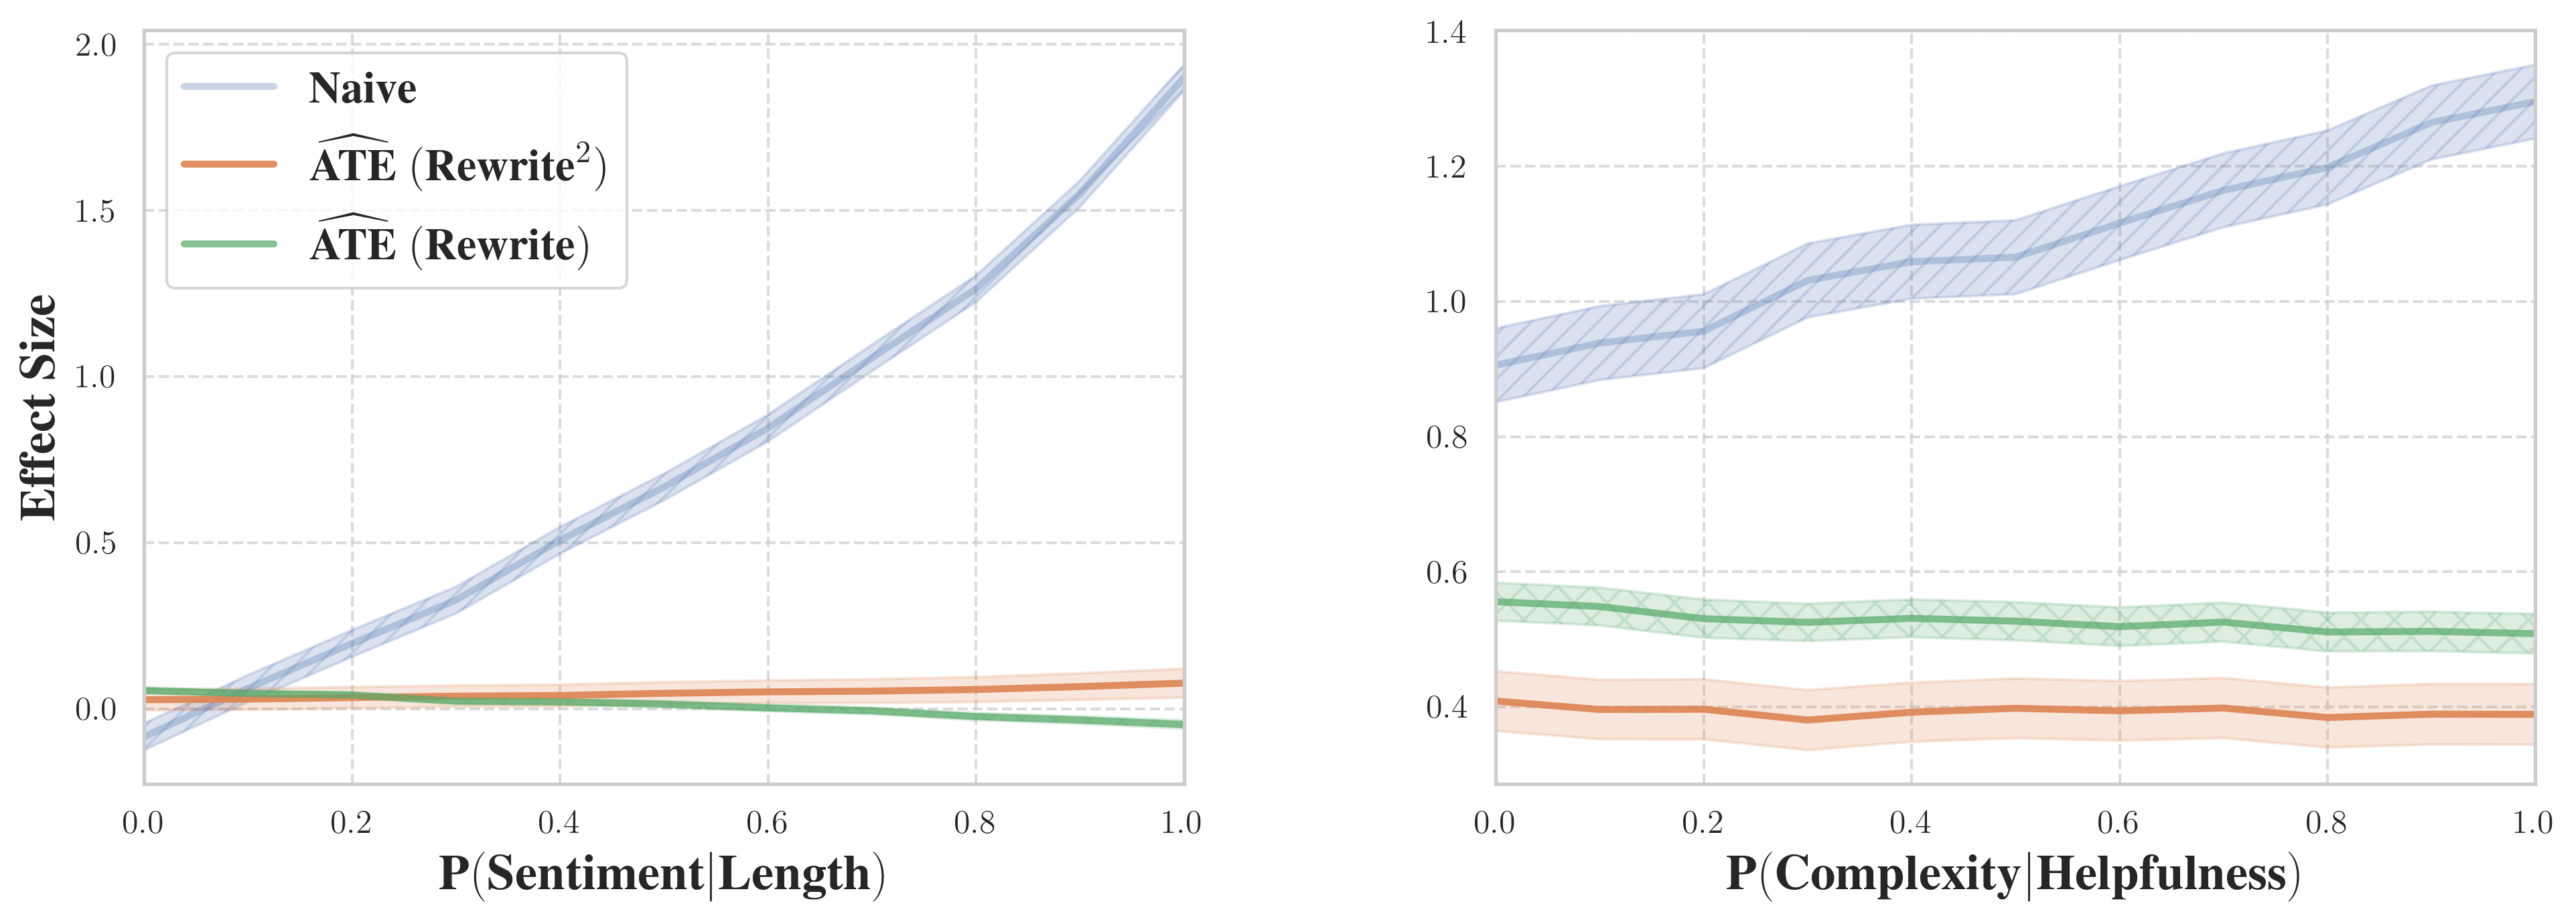

In [14]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")